### EDA

##### Datos

In [27]:
import warnings
warnings.simplefilter("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [28]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/ventas.csv'

# Leer los archivos CSV
#clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [29]:
# Asegúrate de que 'monto_ventas_producto' sea numérico
ventas_df['monto_ventas_producto'] = pd.to_numeric(ventas_df['cantidad_ventas_producto'], errors='coerce')

# Agrupa por tipo de moneda y suma los montos de ventas
suma_por_moneda = ventas_df.groupby('moneda_venta')['cantidad_ventas_producto'].sum()

# Calcular el total de todas las ventas
total_ventas = suma_por_moneda.sum()

# Crear un nuevo DataFrame con los montos y los porcentajes
resultado = pd.DataFrame({
    'Monto Total': suma_por_moneda,
    'Porcentaje del Total': (suma_por_moneda / total_ventas) * 100
})

# Formatear los montos y porcentajes para mejor legibilidad
resultado['Monto Total'] = resultado['Monto Total'].apply(lambda x: f"{x:,.2f}")
resultado['Porcentaje del Total'] = resultado['Porcentaje del Total'].apply(lambda x: f"{x:.2f}%")

# Verificar el resultado
resultado

,Monto Total,Porcentaje del Total
moneda_venta,,
$,"1,460,236.00",99.99%
U$S,140.00,0.01%


Conclusión: Nuestro primer pronóstico agregado va a ser sólo para moneda_venta = $.

In [30]:
# Ver los valores únicos en la columna 'moneda_venta'
print(ventas_df['moneda_venta'].unique())

['$  ' 'U$S']


In [31]:
# Filtrar por tipo de moneda (por ejemplo, solo $)
ventas_filtrado = ventas_df.loc[ventas_df['moneda_venta'] == '$  ']

# Crear la tabla agregada con el DataFrame filtrado
df = ventas_filtrado.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Renombramos variables para que Prophet tome como input
df = df.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})

# Asegurarse de que 'ds' sea un datetime
df['ds'] = pd.to_datetime(df['ds'])

# Revisar los datos resampleados
df.head()


,ds,y
0,2022-04-16,39.000
1,2022-04-17,165.640
2,2022-04-18,2235.130
3,2022-04-19,1167.624
4,2022-04-20,1734.857


##### Para modelar vacaciones y eventos especiales con selección manual

In [32]:
import pandas as pd

# Lista de los nombres de los feriados
holiday_names = ['Año Nuevo', 'Reyes', 'Carnaval', 'Semana Santa', 'Día del Trabajador', 'Natalicio de Artigas', 
                 'Jura de la Constitución', 'Declaratoria de la Independencia', 'Día de la Raza', 'Día de los Difuntos', 'Navidad']

# Fechas base de los feriados (solo un año de ejemplo, luego generaremos para otros años)
holiday_dates = ['01-01', '01-06', '02-12', '03-28', '05-01', '06-19', '07-18', '08-25', '10-12', '11-02', '12-25']

# Crear una lista vacía para almacenar los feriados
all_holidays = []

# Generar los feriados para los años desde 2022 hasta 2026
for year in range(2022, 2027):
    for i, date in enumerate(holiday_dates):
        all_holidays.append({
            'holiday': holiday_names[i],
            'ds': pd.to_datetime(f'{year}-{date}'),
            'lower_window': -3,  # Afecta 3 días antes del feriado
            'upper_window': 3    # Afecta 3 días después del feriado
        })

# Convertir la lista de diccionarios a un DataFrame de pandas
holidays_uruguay = pd.DataFrame(all_holidays)

# Mostrar los primeros datos
holidays_uruguay.head(11)


,holiday,ds,lower_window,upper_window
0,Año Nuevo,2022-01-01,-3,3
1,Reyes,2022-01-06,-3,3
2,Carnaval,2022-02-12,-3,3
3,Semana Santa,2022-03-28,-3,3
4,Día del Trabajador,2022-05-01,-3,3
5,Natalicio de Artigas,2022-06-19,-3,3
6,Jura de la Constitución,2022-07-18,-3,3
7,Declaratoria de la Independencia,2022-08-25,-3,3
8,Día de la Raza,2022-10-12,-3,3
9,Día de los Difuntos,2022-11-02,-3,3


In [33]:
df.head()

,ds,y
0,2022-04-16,39.000
1,2022-04-17,165.640
2,2022-04-18,2235.130
3,2022-04-19,1167.624
4,2022-04-20,1734.857


##### Ingeniería de atributos

In [34]:
import pandas as pd
import numpy as np

# Crear características adicionales a partir de la columna de fechas 'ds'
df['ds'] = pd.to_datetime(df['ds'])
# Asegurarse de que la columna de fechas en holidays_uruguay esté en formato datetime
holidays_uruguay['ds'] = pd.to_datetime(holidays_uruguay['ds'])

# Crear características basadas en la fecha
df['day_of_week'] = df['ds'].dt.dayofweek
df['day_of_month'] = df['ds'].dt.day
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


# Crear características basadas en la fecha
df['day_of_week'] = df['ds'].dt.dayofweek
df['day_of_month'] = df['ds'].dt.day
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['quarter'] = df['ds'].dt.quarter
df['week_of_year'] = df['ds'].dt.isocalendar().week  # Semana del año (ISO)
df['day_of_year'] = df['ds'].dt.dayofyear  # Día del año


# Crear una nueva columna 'is_holiday' en df_train y df_test
df = pd.merge(df, holidays_uruguay[['ds', 'holiday']], on='ds', how='left')
df['is_holiday'] = df['holiday'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Eliminar la columna 'holiday_name' ya que solo queremos 'is_holiday' como input
df = df.drop(columns=['holiday'])

# Rolling window
df['rolling_mean_2'] = df['y'].rolling(window=2, min_periods=1).mean()
df['rolling_mean_7'] = df['y'].rolling(window=7, min_periods=1).mean()
#df['rolling_mean_14'] = df['y'].rolling(window=14, min_periods=1).mean()
#df['rolling_mean_21'] = df['y'].rolling(window=21, min_periods=1).mean()
df['rolling_mean_30'] = df['y'].rolling(window=30, min_periods=1).mean()

# Eliminar filas con valores NaN generados por el rolling
df = df.dropna()

df.head(10)

,ds,y,day_of_week,day_of_month,month,year,is_weekend,quarter,week_of_year,day_of_year,is_holiday,rolling_mean_2,rolling_mean_7,rolling_mean_30
0,2022-04-16,39.000,5,16,4,2022,1,2,15,106,0,39.0000,39.000000,39.000000
1,2022-04-17,165.640,6,17,4,2022,1,2,15,107,0,102.3200,102.320000,102.320000
2,2022-04-18,2235.130,0,18,4,2022,0,2,16,108,0,1200.3850,813.256667,813.256667
3,2022-04-19,1167.624,1,19,4,2022,0,2,16,109,0,1701.3770,901.848500,901.848500
4,2022-04-20,1734.857,2,20,4,2022,0,2,16,110,0,1451.2405,1068.450200,1068.450200
5,2022-04-21,1071.296,3,21,4,2022,0,2,16,111,0,1403.0765,1068.924500,1068.924500
6,2022-04-22,1497.522,4,22,4,2022,0,2,16,112,0,1284.4090,1130.152714,1130.152714
7,2022-04-23,857.400,5,23,4,2022,1,2,16,113,0,1177.4610,1247.067000,1096.058625
8,2022-04-24,8.000,6,24,4,2022,1,2,16,114,0,432.7000,1224.547000,975.163222
9,2022-04-25,977.481,0,25,4,2022,0,2,17,115,0,492.7405,1044.882857,975.395000


In [35]:
# Crear una columna 'is_holiday_2' inicializada en 0
df['is_holiday_2'] = 0

# Iterar sobre cada feriado y marcar los días correspondientes en 'is_holiday_2'
for holiday in holidays_uruguay.itertuples():
    start_date = holiday.ds + pd.Timedelta(days=holiday.lower_window)
    end_date = holiday.ds + pd.Timedelta(days=holiday.upper_window)
    df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date), 'is_holiday_2'] = 1

# Verificar los primeros datos
df.head()

,ds,y,day_of_week,day_of_month,month,year,is_weekend,quarter,week_of_year,day_of_year,is_holiday,rolling_mean_2,rolling_mean_7,rolling_mean_30,is_holiday_2
0,2022-04-16,39.000,5,16,4,2022,1,2,15,106,0,39.0000,39.000000,39.000000,0
1,2022-04-17,165.640,6,17,4,2022,1,2,15,107,0,102.3200,102.320000,102.320000,0
2,2022-04-18,2235.130,0,18,4,2022,0,2,16,108,0,1200.3850,813.256667,813.256667,0
3,2022-04-19,1167.624,1,19,4,2022,0,2,16,109,0,1701.3770,901.848500,901.848500,0
4,2022-04-20,1734.857,2,20,4,2022,0,2,16,110,0,1451.2405,1068.450200,1068.450200,0


In [21]:
df.columns

Index(['ds', 'y', 'day_of_week', 'day_of_month', 'month', 'year', 'is_weekend',
       'quarter', 'week_of_year', 'day_of_year', 'is_holiday',
       'rolling_mean_2', 'rolling_mean_7', 'rolling_mean_30', 'is_holiday_2'],
      dtype='object')

##### Gráfico 0

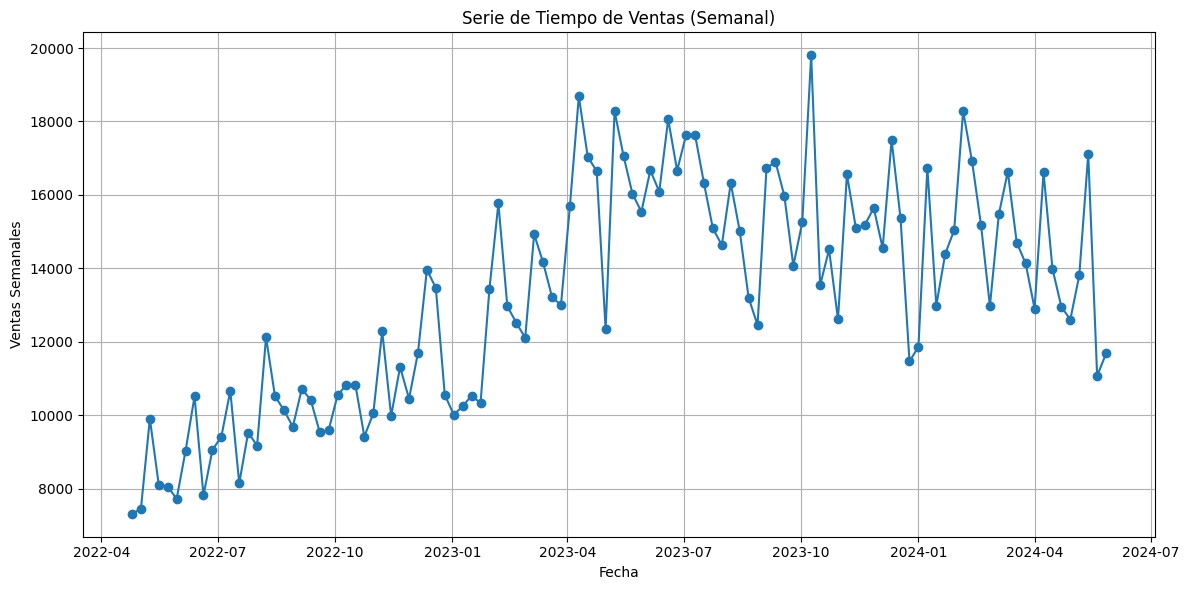

In [25]:
import matplotlib.pyplot as plt

# Resamplear los datos para obtener la suma semanal
df_semanal = df.resample('W-Mon', on='ds').sum().reset_index().sort_values(by='ds')

# Excluir la primera y la última semana
df_semanal = df_semanal.iloc[1:-1]

# Crear el gráfico de línea
plt.figure(figsize=(12, 6))
plt.plot(df_semanal['ds'], df_semanal['y'], marker='o', linestyle='-')

# Añadir títulos y etiquetas
plt.title('Serie de Tiempo de Ventas (Semanal)')
plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

##### Gráfico 0.1

<Figure size 1000x600 with 0 Axes>

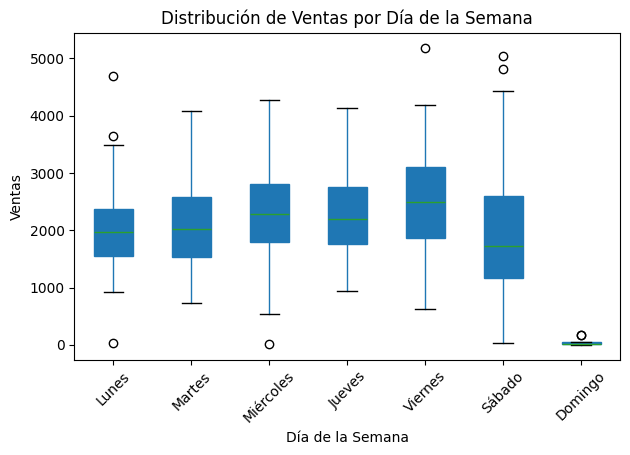

In [39]:
import matplotlib.pyplot as plt

# Crear un diccionario para mapear los números de los días de la semana a nombres
dias_semana = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}

# Mapear los números de los días de la semana a nombres
df['day_of_week_name'] = df['day_of_week'].map(dias_semana)

# Crear el boxplot
plt.figure(figsize=(10, 6))
ax = df.boxplot(column='y', by='day_of_week', grid=False, patch_artist=True)

# Mapear los números de los días de la semana a nombres en el eje x
ax.set_xticklabels([dias_semana[i] for i in sorted(dias_semana.keys())])

# Añadir títulos y etiquetas
plt.title('Distribución de Ventas por Día de la Semana')
plt.suptitle('')  # Eliminar el título automático de pandas
plt.xlabel('Día de la Semana')
plt.ylabel('Ventas')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


##### Gráfico 1

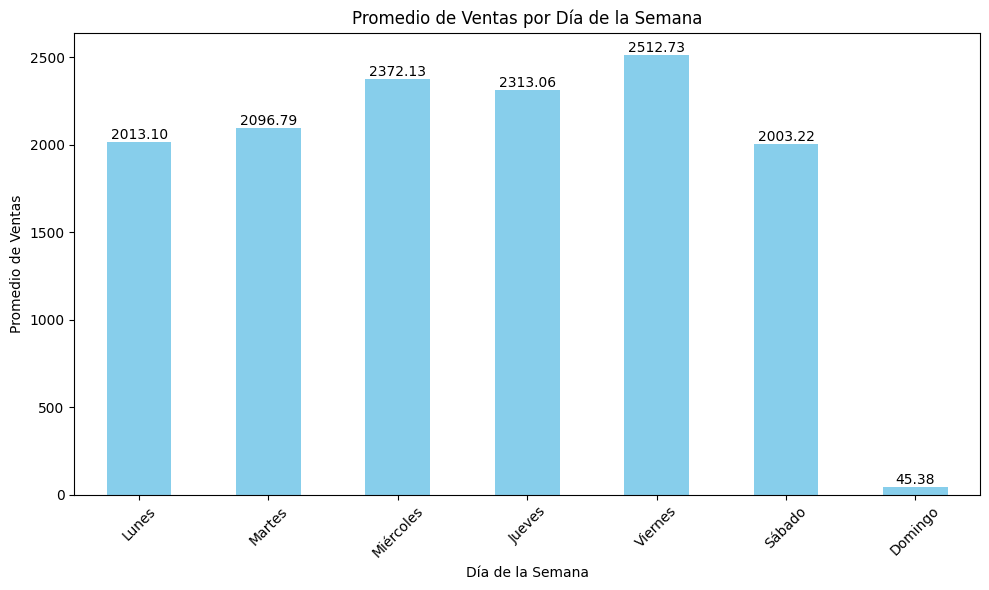

In [22]:
import matplotlib.pyplot as plt

# Crear un diccionario para mapear los números de los días de la semana a nombres
dias_semana = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}

# Mapear los números de los días de la semana a nombres
df['day_of_week_name'] = df['day_of_week'].map(dias_semana)

# Agrupar por 'day_of_week_name' y calcular el promedio de 'y'
promedio_ventas_dia = df.groupby('day_of_week_name')['y'].mean().reindex(['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])

# Crear el gráfico de barras
ax_dia = promedio_ventas_dia.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Añadir títulos y etiquetas
plt.title('Promedio de Ventas por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Promedio de Ventas')
plt.xticks(rotation=45)
plt.tight_layout()

# Añadir etiquetas con el promedio de cada categoría
for i in ax_dia.containers:
    ax_dia.bar_label(i, fmt='%.2f', label_type='edge')

# Mostrar el gráfico
plt.show()

##### Gráfico 2

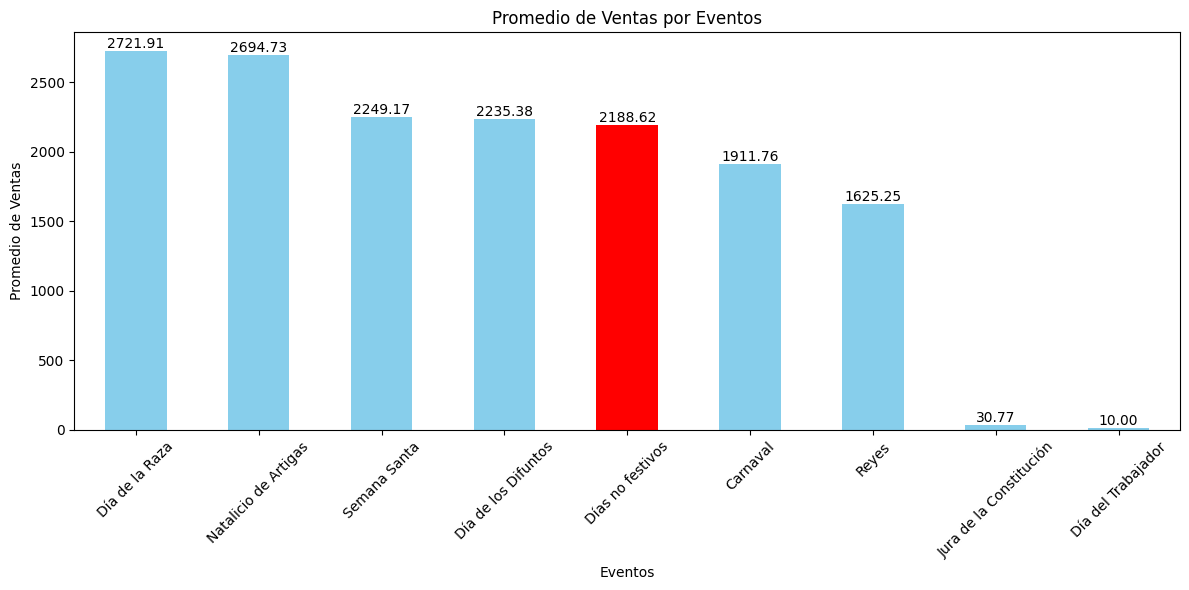

In [30]:
# Crear la tabla df_2 uniendo df con holidays_uruguay
df_2 = pd.merge(df, holidays_uruguay[['ds', 'holiday']], on='ds', how='left')

# Rellenar los valores NaN en la columna 'holiday' con 'Días no festivos'
df_2['holiday'] = df_2['holiday'].fillna('Días no festivos')

# Calcular el promedio de 'y' para cada etiqueta de holiday
promedio_ventas_holiday = df_2.groupby('holiday')['y'].mean().sort_values(ascending=False)

# Crear el gráfico de barras con la barra de "Días no festivos" en rojo
colors = ['red' if holiday == 'Días no festivos' else 'skyblue' for holiday in promedio_ventas_holiday.index]
ax_holiday = promedio_ventas_holiday.plot(kind='bar', figsize=(12, 6), color=colors)

# Añadir títulos y etiquetas
plt.title('Promedio de Ventas por Eventos')
plt.xlabel('Eventos')
plt.ylabel('Promedio de Ventas')
plt.xticks(rotation=45)
plt.tight_layout()

# Añadir etiquetas con el promedio de cada categoría
for i in ax_holiday.containers:
    ax_holiday.bar_label(i, fmt='%.2f', label_type='edge')

# Mostrar el gráfico
plt.show()

##### Gráfico 3

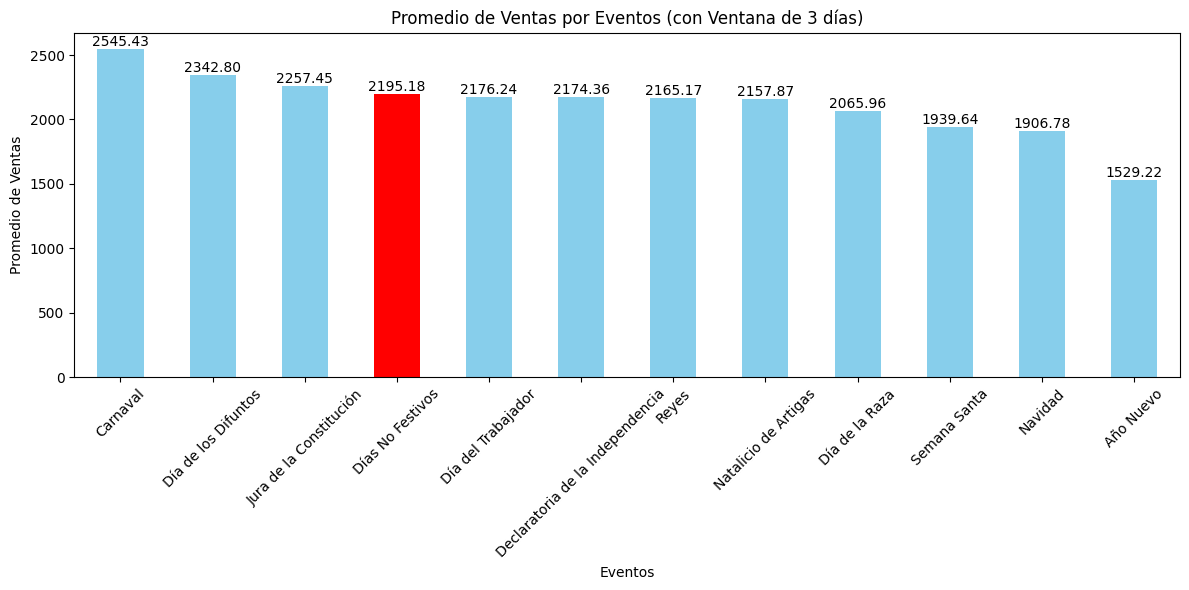

In [37]:
import matplotlib.pyplot as plt

# Crear una columna 'is_holiday_window' inicializada en 0
df['is_holiday_window'] = 0

# Iterar sobre cada feriado y marcar los días correspondientes en 'is_holiday_window'
for holiday in holidays_uruguay.itertuples():
    start_date = holiday.ds + pd.Timedelta(days=holiday.lower_window)
    end_date = holiday.ds + pd.Timedelta(days=holiday.upper_window)
    df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date), 'is_holiday_window'] = 1
    df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date), 'holiday_name'] = holiday.holiday

# Reemplazar NaN en 'holiday_name' con 'Días No Festivos'
df['holiday_name'] = df['holiday_name'].fillna('Días no festivos')

# Agrupar por 'holiday_name' y calcular el promedio de 'y'
promedio_ventas_holiday_window = df.groupby('holiday_name')['y'].mean()

# Ordenar de mayor a menor
promedio_ventas_holiday_window = promedio_ventas_holiday_window.sort_values(ascending=False)

# Crear el gráfico de barras con la barra de días no festivos en rojo
colors = ['red' if holiday == 'Días No Festivos' else 'skyblue' for holiday in promedio_ventas_holiday_window.index]
ax_holiday_window = promedio_ventas_holiday_window.plot(kind='bar', figsize=(12, 6), color=colors)

# Añadir títulos y etiquetas
plt.title('Promedio de Ventas por Eventos (con Ventana de 3 días)')
plt.xlabel('Eventos')
plt.ylabel('Promedio de Ventas')
plt.xticks(rotation=45)
plt.tight_layout()

# Añadir etiquetas con el promedio de cada categoría
for i in ax_holiday_window.containers:
    ax_holiday_window.bar_label(i, fmt='%.2f', label_type='edge')

# Mostrar el gráfico
plt.show()

##### Gráfico 4

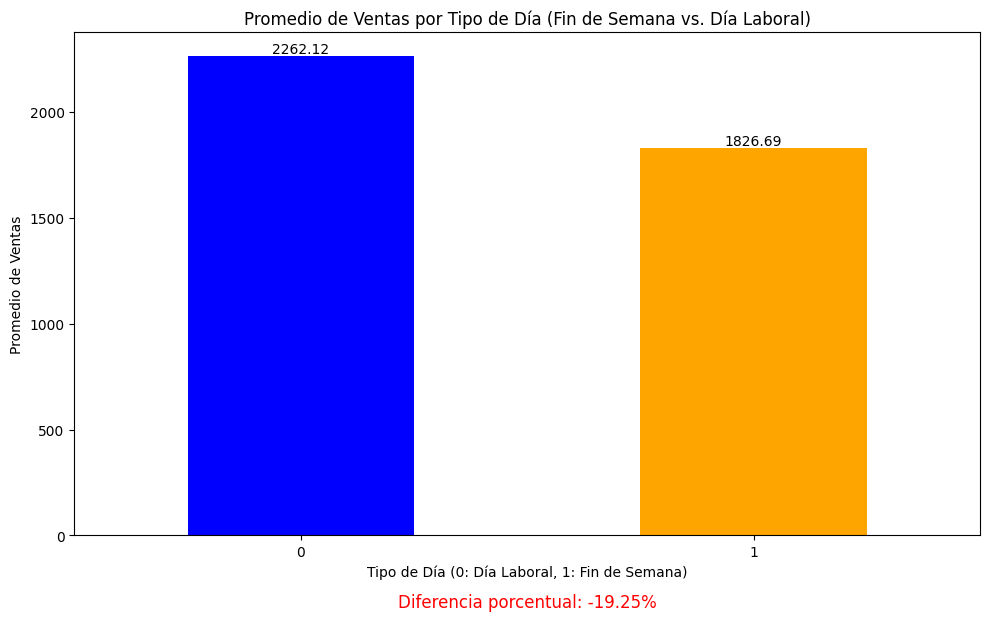

In [42]:
import matplotlib.pyplot as plt

# Agrupar por 'is_weekend' y calcular el promedio de 'y'
promedio_ventas_weekend = df.groupby('is_weekend')['y'].mean()

# Crear el gráfico de barras
ax_weekend = promedio_ventas_weekend.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])

# Añadir títulos y etiquetas
plt.title('Promedio de Ventas por Tipo de Día (Fin de Semana vs. Día Laboral)')
plt.xlabel('Tipo de Día (0: Día Laboral, 1: Fin de Semana)')
plt.ylabel('Promedio de Ventas')
plt.xticks(rotation=0)
plt.tight_layout()

# Añadir etiquetas con el promedio de cada categoría
for i in ax_weekend.containers:
    ax_weekend.bar_label(i, fmt='%.2f', label_type='edge')

# Calcular la diferencia porcentual
diferencia_porcentual_weekend = ((promedio_ventas_weekend[1] - promedio_ventas_weekend[0]) / promedio_ventas_weekend[0]) * 100

# Añadir la descripción de la variación más abajo
descripcion_variacion_weekend = f"Diferencia porcentual: {diferencia_porcentual_weekend:.2f}%"
plt.text(0.5, -0.15, descripcion_variacion_weekend, ha='center', va='bottom', fontsize=12, color='red', transform=ax_weekend.transAxes)

# Mostrar el gráfico
plt.show()

##### Gráfico 5

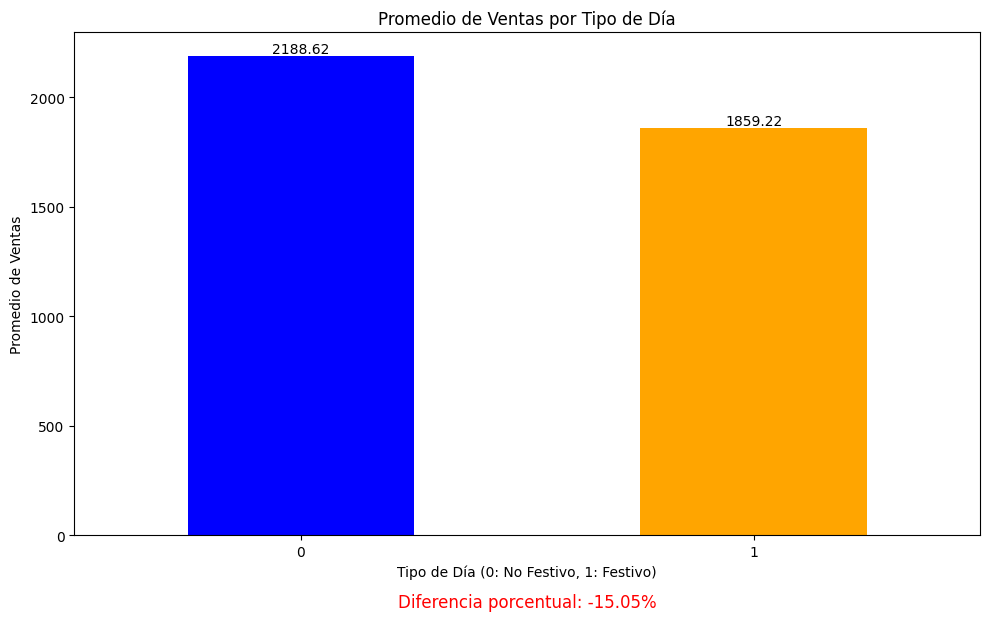

In [40]:
import matplotlib.pyplot as plt

# Agrupar por 'is_holiday' y calcular el promedio de 'y'
promedio_ventas = df.groupby('is_holiday')['y'].mean()

# Crear el gráfico de barras
ax = promedio_ventas.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])

# Añadir títulos y etiquetas
plt.title('Promedio de Ventas por Tipo de Día')
plt.xlabel('Tipo de Día (0: No Festivo, 1: Festivo)')
plt.ylabel('Promedio de Ventas')
plt.xticks(rotation=0)
plt.tight_layout()

# Añadir etiquetas con el promedio de cada categoría
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', label_type='edge')

# Calcular la diferencia porcentual
diferencia_porcentual = ((promedio_ventas[1] - promedio_ventas[0]) / promedio_ventas[0]) * 100

# Añadir la descripción de la variación más abajo
descripcion_variacion = f"Diferencia porcentual: {diferencia_porcentual:.2f}%"
plt.text(0.5, -0.15, descripcion_variacion, ha='center', va='bottom', fontsize=12, color='red', transform=ax.transAxes)

# Mostrar el gráfico
plt.show()

##### Gráfico 6

El top 10 productos representan el 38.13% de las ventas totales.


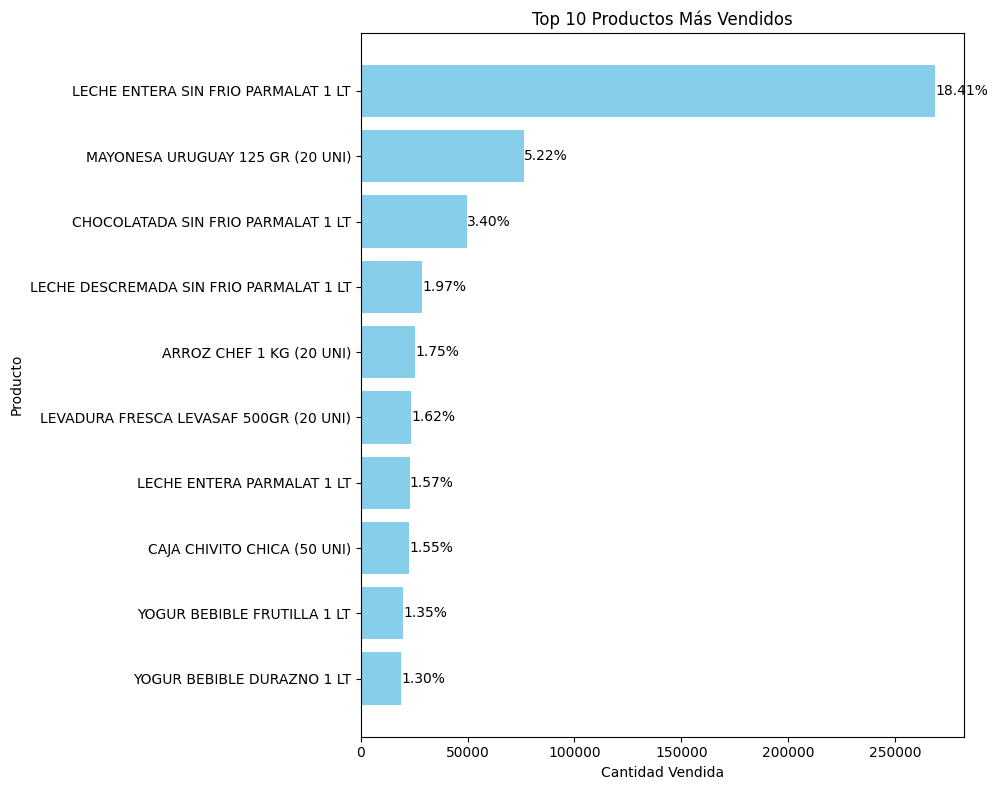

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponiendo que 'ventas_df' es tu DataFrame original y 'productos_df' contiene las descripciones
ventas_totales = ventas_df.groupby('codigo_producto')['cantidad_ventas_producto'].sum().reset_index()

# Agregar el nombre del producto desde productos_df
ventas_totales = ventas_totales.merge(productos_df[['codigo_producto', 'descripcion_producto']], on='codigo_producto')

# Ordenar el DataFrame por la cantidad total vendida en orden descendente
ventas_totales = ventas_totales.sort_values(by='cantidad_ventas_producto', ascending=False)

# Calcular el total de ventas para calcular el porcentaje
total_ventas = ventas_totales['cantidad_ventas_producto'].sum()

# Filtrar los primeros 10 productos más vendidos
top_n_productos = ventas_totales.head(10)

# Calcular el porcentaje que cada producto representa sobre el total de ventas
top_n_productos['porcentaje'] = (top_n_productos['cantidad_ventas_producto'] / total_ventas) * 100

# Calcular el porcentaje total representado por el top 10 de productos
porcentaje_total_top_20 = top_n_productos['porcentaje'].sum()

# Mostrar el resultado
print(f"El top 10 productos representan el {porcentaje_total_top_20:.2f}% de las ventas totales.")

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 8))
bars = plt.barh(top_n_productos['descripcion_producto'], top_n_productos['cantidad_ventas_producto'], color='skyblue')

# Invertir el eje Y para que el producto más vendido esté en la parte superior
plt.gca().invert_yaxis()

# Agregar los porcentajes como etiquetas en el gráfico
for bar, porcentaje in zip(bars, top_n_productos['porcentaje']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{porcentaje:.2f}%', 
             va='center', ha='left')

# Agregar títulos y etiquetas
plt.title('Top 10 Productos Más Vendidos')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Producto')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

##### Gráfico 7

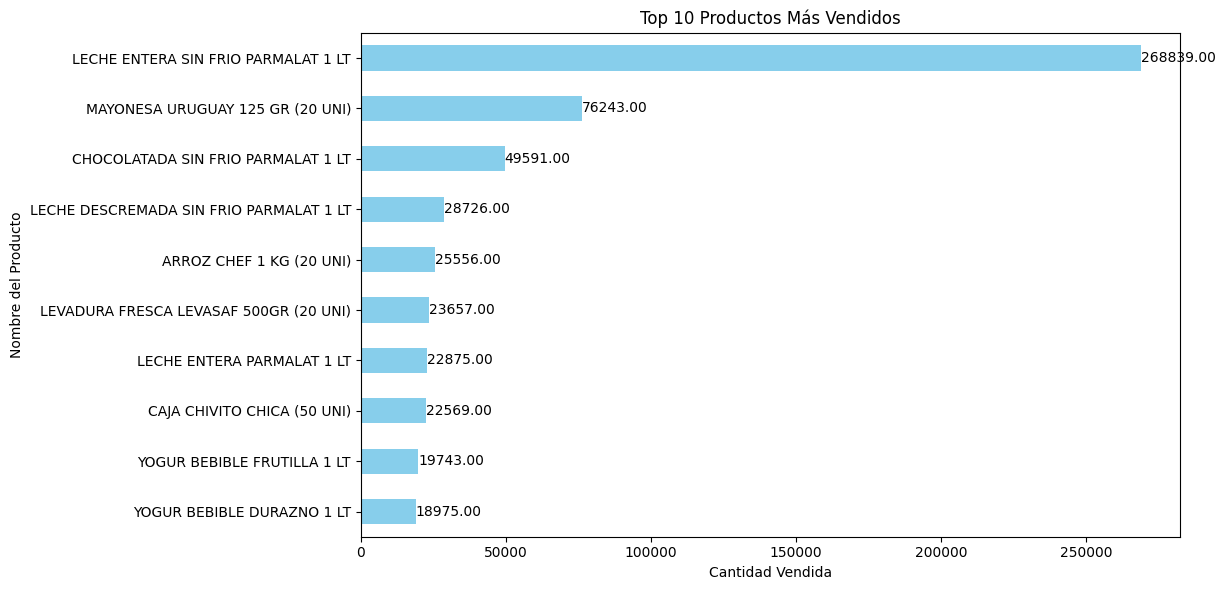

In [44]:
import matplotlib.pyplot as plt

# Agrupar por 'codigo_producto' y sumar las cantidades vendidas
ventas_por_producto = ventas_df.groupby('codigo_producto')['cantidad_ventas_producto'].sum()

# Obtener los 10 productos más vendidos y ordenarlos de mayor a menor
top_10_productos = ventas_por_producto.nlargest(10).sort_values(ascending=True)

# Obtener los nombres de los productos
top_10_productos_nombres = top_10_productos.index.map(lambda x: productos_df.loc[productos_df['codigo_producto'] == x, 'descripcion_producto'].values[0])

# Crear el gráfico de barras horizontal
ax_top_10 = top_10_productos.plot(kind='barh', figsize=(12, 6), color='skyblue')

# Añadir títulos y etiquetas
plt.title('Top 10 Productos Más Vendidos')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Nombre del Producto')
plt.yticks(ticks=range(len(top_10_productos)), labels=top_10_productos_nombres)
plt.tight_layout()

# Añadir etiquetas con la cantidad vendida de cada producto
for i in ax_top_10.containers:
    ax_top_10.bar_label(i, fmt='%.2f', label_type='edge')

# Mostrar el gráfico
plt.show()